In [187]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, SGDRegressor, BayesianRidge
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import sqlite3
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
import tensorflow as tf
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow import keras
from sklearn.kernel_ridge import KernelRidge
import pickle
from sklearn.decomposition import PCA

In [214]:
database = "data.sqlite"

conn = sqlite3.connect(database)

train_df = pd.read_sql("select * from new_table_name", con=conn)
train_df.head()

,Unnamed: 0,year,make,model,final_price,mileage,engine,zipcode,engine string
0,1,1997,Chevrolet,Chevrolet Suburban,"$17,000",67000,5700.0,60069,5.7L Vortec V8
1,2,1990,Porsche,Porsche 964 911,"$225,000",1000,3800.0,84790,3.8-Liter Flat-Six
2,3,2003,Toyota,Toyota Pickup,"$24,750",116000,3400.0,90027,3.4-Liter DOHC V6
3,5,1992,Volkswagen,Volkswagen Golf/Rabbit Cabriolet,"$10,750",100000,1800.0,98208,1.8-Liter Inline-Four
4,6,2008,Toyota,Toyota FJ Cruiser,"$32,500",9000,4000.0,57108,4.0-Liter V6


In [215]:
conn.close()

In [216]:
train_df['final_price']=(train_df['final_price'].replace( '[\$,)]','', regex=True )
               .replace( '[(]','-',   regex=True ).astype(float))

In [217]:
train_df = train_df.drop(['model', 'engine string', 'Unnamed: 0', 'zipcode'], axis='columns')
train_df

,year,make,final_price,mileage,engine
0,1997,Chevrolet,17000.0,67000,5700.0
1,1990,Porsche,225000.0,1000,3800.0
2,2003,Toyota,24750.0,116000,3400.0
3,1992,Volkswagen,10750.0,100000,1800.0
4,2008,Toyota,32500.0,9000,4000.0
...,...,...,...,...,...
7100,1983,Jeep,39962.0,24000,4200.0
7101,1997,Ford,24900.0,75000,7300.0
7102,1972,Honda,2400.0,5000,174.0
7103,2005,Ford,17750.0,22000,3900.0


In [218]:
train_df.make.value_counts()

Porsche          1108
BMW               796
Chevrolet         782
Mercedes-Benz     734
Ford              697
                 ... 
Alpine              1
Nash                1
Bricklin            1
Opel                1
Renault             1
Name: make, Length: 68, dtype: int64

In [219]:
train_df1 = train_df.apply(lambda x: x.mask(x.map(x.value_counts())<100, 'other') if x.name=='make' else x)
train_df1.make.value_counts()

other            1547
Porsche          1108
BMW               796
Chevrolet         782
Mercedes-Benz     734
Ford              697
Toyota            315
Honda             200
Land Rover        174
Volkswagen        168
Jaguar            163
Jeep              161
Ferrari           150
Pontiac           110
Name: make, dtype: int64

In [220]:
train_df1 = train_df1.query('make != "other"')
train_df1.make.value_counts()

Porsche          1108
BMW               796
Chevrolet         782
Mercedes-Benz     734
Ford              697
Toyota            315
Honda             200
Land Rover        174
Volkswagen        168
Jaguar            163
Jeep              161
Ferrari           150
Pontiac           110
Name: make, dtype: int64

In [221]:
# Convert categorical data to numeric and separate target feature for training data
train_df2 = pd.get_dummies(train_df1)
train_df2.head()

,year,final_price,mileage,engine,make_BMW,make_Chevrolet,make_Ferrari,make_Ford,make_Honda,make_Jaguar,make_Jeep,make_Land Rover,make_Mercedes-Benz,make_Pontiac,make_Porsche,make_Toyota,make_Volkswagen
0,1997,17000.0,67000,5700.0,0,1,0,0,0,0,0,0,0,0,0,0,0
1,1990,225000.0,1000,3800.0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,2003,24750.0,116000,3400.0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,1992,10750.0,100000,1800.0,0,0,0,0,0,0,0,0,0,0,0,0,1
4,2008,32500.0,9000,4000.0,0,0,0,0,0,0,0,0,0,0,0,1,0


In [222]:
train_X = train_df2.drop(columns='final_price')
train_y = train_df2['final_price']

In [223]:
X_train, X_test, y_train, y_test = train_test_split(train_X, train_y, random_state=42)

In [224]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [225]:
#pca = PCA(n_components = .7, svd_solver='full')
#X_train_scaled = pca.fit_transform(X_train_scaled)
#X_test_scaled = pca.fit_transform(X_test_scaled)

In [226]:
#X_train_scaled[0]

In [227]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)
print(f'Model Score: {model.score(X_train_scaled, y_train)}')
print(f'Model Score: {model.score(X_test_scaled, y_test)}')

Model Score: 0.15443675967807258
Model Score: 0.21718198551808188


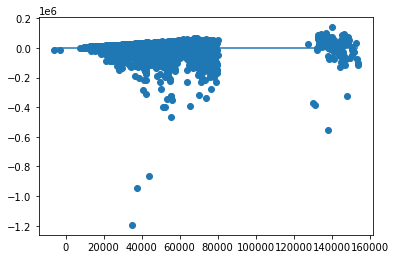

In [228]:
predictions = model.predict(X_train_scaled)
# Plot Residuals
plt.scatter(predictions, predictions - y_train)
plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max())
plt.show()

In [229]:
print('Weight coefficients: ', model.coef_)
print('y-axis intercept: ', model.intercept_)
print(f"True output: {train_y[0]}")
print(f"Predicted output: {predictions[0]}")
print(f"Prediction Error: {predictions[0]-y_train[0]}")

x_min = X_train_scaled.min()
x_max = X_train_scaled.max()
y_min_actual = y_train.min()
y_max_actual = y_train.max()

y_min = 101.896225057 + (model.coef_ * x_min)
y_max = 101.896225057 + (model.coef_ * x_max)
print(f"Actual Min Value: {y_min_actual}")
print(f"Calculated Min Value: {y_min}")
print(f"Actual Max Value: {y_max_actual}")
print(f"Calculated Max Value: {y_max}")

# y_min_predicted = model.predict([[x_min]])
# y_max_predicted = model.predict([[x_max]])
# print(f"Actual Min Value: {y_min_actual}")
# print(f"Predicted Min Value: {y_min_predicted}")
# print(f"Actual Max Value: {y_max_actual}")
# print(f"Predicted Max Value: {y_max_predicted}")

# plt.scatter(X, y, c='blue')
# plt.plot([x_min, x_max], [y_min, y_max], c='red')

Weight coefficients:  [ 3031.28446184 -3240.1537691   5508.56183572 -4386.93585774
 -2843.1422761  14531.18508125  -654.60166078 -3976.73282796
  1604.80984265 -3659.26571614 -1244.55380163 -2493.92145486
 -2560.79119558  9814.67124578 -2607.5331494  -2120.30484688]
y-axis intercept:  47547.579174664126
True output: 17000.0
Predicted output: 55527.026635358656
Prediction Error: 38527.026635358656
Actual Min Value: 0.0
Calculated Min Value: [-12312.29200377  13371.47857086 -22457.62412338  18067.95918331
  11745.57527308 -59408.47604705   2782.72289576  16388.03184959
  -6470.37098014  15087.89109008   5198.78678379  10315.39177728
  10589.24715399 -40092.67402499  10780.67208299   8785.2988562 ]
Actual Max Value: 1230000.0
Calculated Max Value: [ 20985.90985192 -22221.1210697   38053.09542455 -30121.8684485
 -19485.9130963  100214.39674156  -4407.97745257 -27295.77747236
  11158.22269141 -25108.58997061  -8472.4487036  -17079.95862997
 -17540.65725266  67720.0068381  -17862.68562472 -1

In [230]:
reg = Lasso(max_iter=10000).fit(X_train_scaled, y_train)
print(f'Train score: {reg.score(X_train_scaled, y_train)}')
print(f'Test Score: {reg.score(X_test_scaled, y_test)}')

Train score: 0.15443675563871473
Test Score: 0.21718476540012654


C:\Users\austi\anaconda3\envs\PythonData\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1732876561.5136719, tolerance: 1355047774.9763873
  model = cd_fast.enet_coordinate_descent(


In [231]:
reg = Ridge(alpha=100).fit(X_train_scaled, y_train)
print(f'Train score: {reg.score(X_train_scaled, y_train)}')
print(f'Test Score: {reg.score(X_test_scaled, y_test)}')

Train score: 0.154361379136857
Test Score: 0.2167348253804795


In [232]:
reg = ElasticNet(alpha=10).fit(X_train_scaled, y_train)
print(f'Train score: {reg.score(X_train_scaled, y_train)}')
print(f'Test Score: {reg.score(X_test_scaled, y_test)}')

Train score: 0.053528846531619045
Test Score: 0.07247393755826426


In [288]:
def test_model(model, data):
    X_train_scaled, X_test_scaled, y_train, y_test = data
    reg = model.fit(X_train_scaled, y_train)
    print(f'Model: {type(reg).__name__}')
    print(f'Train score: {reg.score(X_train_scaled, y_train)}')
    print(f'Test Score: {reg.score(X_test_scaled, y_test)}')
    plt.show()
    y_pred = reg.predict(X_test_scaled)
    print(mean_absolute_error(y_test, y_pred))    
    print(mean_squared_error(y_test, y_pred)) 
    print(np.median(abs(y_test - y_pred)))
    print('\n')
    return [
        mean_absolute_error(y_test, y_pred),
        mean_squared_error(y_test, y_pred),
        np.median(abs(y_test - y_pred)),
        y_pred,
        reg]


In [234]:
data = [X_train_scaled, X_test_scaled, y_train, y_test]

In [235]:
test_model(KNeighborsRegressor(), data)
test_model(RandomForestRegressor(), data)
test_model(ExtraTreesRegressor(), data)
test_model(AdaBoostRegressor(), data)
test_model(SVR(C=1.0, epsilon=0.2), data)
test_model(GradientBoostingRegressor(), data)
test_model(SGDRegressor(), data)
test_model(KernelRidge(), data)
test_model(BayesianRidge(), data)

Model: KNeighborsRegressor
Train score: 0.5810280331784604
Test Score: 0.31916297026880314
20715.426762589927
1785007748.7544746
9020.0


Model: RandomForestRegressor
Train score: 0.9058758726158886
Test Score: 0.5094539292439506
17962.76392668722
1286105924.3007367
8223.404999999999


Model: ExtraTreesRegressor
Train score: 0.9917417999798728
Test Score: 0.5761251973056897
17532.26951678657
1111308248.9209514
8070.584999999999


Model: AdaBoostRegressor
Train score: -3.9770668175118162
Test Score: -5.1446522323509924
114768.17334738695
16109951969.678276
107576.01092686906


Model: SVR
Train score: -0.09016351565708192
Test Score: -0.11404139610824893
28864.99180152041
2920776100.0772696
14643.356136399378


Model: GradientBoostingRegressor
Train score: 0.5908531738404579
Test Score: 0.4632547067783588
20589.295559674207
1407230314.5532346
12114.580010201022


Model: SGDRegressor
Train score: 0.15334078365432902
Test Score: 0.21058467136274517
27873.80388677622
2069676614.3278012
1969

[27495.071553842616, 2053488091.8162699, 19285.10644867214, BayesianRidge()]

In [245]:
mse_list = []
mae_list = []
median_list = []
for i in range(5,30):
    for j in range(10, 1001, 10):
        val1, val2, val3, ypred, model = test_model(RandomForestRegressor(max_depth = i, n_estimators = j, n_jobs = -1, random_state=12), data)
        mse_list.append(val2)
        mae_list.append(val1)
        median_list.append(val3)
    

Model: RandomForestRegressor
Train score: 0.5145260500419726
Test Score: 0.3690894507087493
22851.068590642215
1654111292.5371504
14618.788923024978


Model: RandomForestRegressor
Train score: 0.5052210632508392
Test Score: 0.33394176203161585
23188.44749469295
1746260946.4187315
14995.110446079232


Model: RandomForestRegressor
Train score: 0.5249736720531315
Test Score: 0.3435719088277587
23066.416492016604
1721012779.9675837
14999.14207658508


Model: RandomForestRegressor
Train score: 0.5244869303115782
Test Score: 0.3287905400630483
23143.819767226254
1759766338.6461155
15062.172675362212


Model: RandomForestRegressor
Train score: 0.5279112223101721
Test Score: 0.337378813901833
23107.633366826656
1737249738.2245603
15040.870201215417


Model: RandomForestRegressor
Train score: 0.5313018404367558
Test Score: 0.34466784455686206
23024.53554064212
1718139473.0186963
15020.230464105069


Model: RandomForestRegressor
Train score: 0.5334522364604761
Test Score: 0.3489005283157106
2299

14864.249517835622


Model: RandomForestRegressor
Train score: 0.5258908775299743
Test Score: 0.3640937327565602
22833.41162051684
1667208986.7955987
14884.545534896984


Model: RandomForestRegressor
Train score: 0.5257366604126057
Test Score: 0.3640209245012773
22832.818682257624
1667399874.3269434
14864.14704446109


Model: RandomForestRegressor
Train score: 0.5258180118136218
Test Score: 0.36421431239332724
22828.845063001045
1666892853.01237
14874.299231702582


Model: RandomForestRegressor
Train score: 0.5262194347388945
Test Score: 0.36322432276647443
22842.624782247676
1669488392.1472151
14902.677999473075


Model: RandomForestRegressor
Train score: 0.5259936287681963
Test Score: 0.3630945835641026
22847.81983930646
1669828540.3345752
14890.802734566398


Model: RandomForestRegressor
Train score: 0.5258487274283756
Test Score: 0.36322086216500815
22842.619480841633
1669497465.0973675
14881.259786636834


Model: RandomForestRegressor
Train score: 0.5256477350824388
Test Score: 0.

Train score: 0.5974524828147669
Test Score: 0.4124867936821328
21517.48030791446
1540332825.5912073
13374.762545820126


Model: RandomForestRegressor
Train score: 0.5968169655876214
Test Score: 0.412157418823648
21520.354200332455
1541196375.3820765
13428.350325313528


Model: RandomForestRegressor
Train score: 0.595792900693512
Test Score: 0.4112665813231753
21521.03338372773
1543531959.0412855
13426.942533005027


Model: RandomForestRegressor
Train score: 0.5943850026682358
Test Score: 0.4099730159108571
21515.03453213951
1546923408.3656864
13444.090384618343


Model: RandomForestRegressor
Train score: 0.5938658159098136
Test Score: 0.4095411726284288
21511.10936227033
1548055608.2486541
13388.397114954667


Model: RandomForestRegressor
Train score: 0.5931532236786663
Test Score: 0.4112705295294933
21499.883223493012
1543521607.6964507
13401.771106479096


Model: RandomForestRegressor
Train score: 0.5931615839435824
Test Score: 0.41159913598154874
21493.780113835124
1542660072.501396

Model: RandomForestRegressor
Train score: 0.5907012424879721
Test Score: 0.40982061569044514
21544.569149790033
1547322968.8514824
13417.229202456729


Model: RandomForestRegressor
Train score: 0.5906090822890986
Test Score: 0.4102472159917092
21540.406123544893
1546204514.9335482
13395.920294616086


Model: RandomForestRegressor
Train score: 0.5904200835704004
Test Score: 0.4097850876238427
21541.9432454422
1547416115.7741883
13367.545659431242


Model: RandomForestRegressor
Train score: 0.590531347503382
Test Score: 0.40983225749796337
21543.68998672262
1547292446.544789
13356.278923051783


Model: RandomForestRegressor
Train score: 0.5904954889378489
Test Score: 0.41052634688728706
21541.20531618499
1545472693.9694037
13375.655576031955


Model: RandomForestRegressor
Train score: 0.5905619968070357
Test Score: 0.41106212536812425
21534.29385882754
1544067998.428258
13373.206922608535


Model: RandomForestRegressor
Train score: 0.5907446573421239
Test Score: 0.41048440425857446
21538

Model: RandomForestRegressor
Train score: 0.6535952933206439
Test Score: 0.44809275485973565
20489.907032553776
1446981680.1211011
12228.004893539393


Model: RandomForestRegressor
Train score: 0.6530863401134248
Test Score: 0.4484780353836787
20469.455297114146
1445971557.7413678
12210.723222137001


Model: RandomForestRegressor
Train score: 0.65250840395656
Test Score: 0.4491483430379756
20463.70694464618
1444214155.742476
12194.745341821463


Model: RandomForestRegressor
Train score: 0.6525472745657162
Test Score: 0.44674219711844676
20485.67527991824
1450522551.0315635
12188.316803680484


Model: RandomForestRegressor
Train score: 0.6526323559549527
Test Score: 0.4464652602586141
20483.411751800166
1451248619.7075174
12195.367521102758


Model: RandomForestRegressor
Train score: 0.6520535539174008
Test Score: 0.4459944131178887
20486.296365162692
1452483079.288844
12229.128369993889


Model: RandomForestRegressor
Train score: 0.6521994419458551
Test Score: 0.443581063740461
20513.4

20531.746708149163
1463504375.4946423
12154.568244142582


Model: RandomForestRegressor
Train score: 0.6500131084073816
Test Score: 0.442106450383571
20531.535128901094
1462676478.4498231
12151.440832307253


Model: RandomForestRegressor
Train score: 0.6498690006650243
Test Score: 0.4423736688567842
20530.785200798004
1461975889.2860932
12143.73978601563


Model: RandomForestRegressor
Train score: 0.6493969676820706
Test Score: 0.44206616062755244
20530.837613664084
1462782109.4944758
12157.334846791957


Model: RandomForestRegressor
Train score: 0.6490900957481602
Test Score: 0.4416921604639358
20533.935178467218
1463762657.2040424
12163.220560984768


Model: RandomForestRegressor
Train score: 0.6489240040479257
Test Score: 0.4415042977577852
20538.81676364629
1464255192.6736736
12149.195121132223


Model: RandomForestRegressor
Train score: 0.6487588132447963
Test Score: 0.44110024381386237
20540.542317181393
1465314534.9087775
12151.646401547576


Model: RandomForestRegressor
Train s

Model: RandomForestRegressor
Train score: 0.704198843278053
Test Score: 0.4704460268631089
19726.940650105844
1388376225.374036
11411.293270244503


Model: RandomForestRegressor
Train score: 0.7042954093789244
Test Score: 0.47007171765302747
19727.757492484834
1389357583.3367329
11454.042173812482


Model: RandomForestRegressor
Train score: 0.7038207008694208
Test Score: 0.4704481641921904
19731.397946900408
1388370621.7584784
11474.88233624621


Model: RandomForestRegressor
Train score: 0.7038165501630606
Test Score: 0.46959339339323336
19735.972543204705
1390611646.3104916
11490.390527128702


Model: RandomForestRegressor
Train score: 0.7040907500420122
Test Score: 0.46922301130510435
19745.68244593417
1391582708.207009
11412.358418921402


Model: RandomForestRegressor
Train score: 0.7040048079296491
Test Score: 0.4685631777177379
19752.970235847948
1393312649.4629989
11461.287064728635


Model: RandomForestRegressor
Train score: 0.7039998102678957
Test Score: 0.4684120354948774
1976

Model: RandomForestRegressor
Train score: 0.7027509008361019
Test Score: 0.46819367934750644
19752.6593949678
1394281394.4419196
11431.479787297385


Model: RandomForestRegressor
Train score: 0.7028795079197927
Test Score: 0.4671956545566073
19754.998083232924
1396898000.0426862
11428.827663371128


Model: RandomForestRegressor
Train score: 0.7029343673980311
Test Score: 0.467727980919566
19752.309931546588
1395502355.2095568
11435.664743683072


Model: RandomForestRegressor
Train score: 0.7028340713078941
Test Score: 0.46778538534096337
19756.010413458687
1395351853.2060924
11443.125445448539


Model: RandomForestRegressor
Train score: 0.7027405468817607
Test Score: 0.467965292026138
19753.927824947416
1394880176.7063344
11448.455544664797


Model: RandomForestRegressor
Train score: 0.702644268578418
Test Score: 0.46809372491930945
19754.954083003944
1394543453.3797603
11416.89953077804


Model: RandomForestRegressor
Train score: 0.7028484938281843
Test Score: 0.4675284735879003
19759

Model: RandomForestRegressor
Train score: 0.7526285440390889
Test Score: 0.4913755198025347
19114.80795388098
1333503612.0422862
10634.996569718673


Model: RandomForestRegressor
Train score: 0.7527963548454806
Test Score: 0.49145828678028347
19113.604644408173
1333286614.89
10641.54406308827


Model: RandomForestRegressor
Train score: 0.7526626062369255
Test Score: 0.4904947686006669
19108.4992222678
1335812751.6034522
10642.792349050207


Model: RandomForestRegressor
Train score: 0.7523908418237817
Test Score: 0.4900680035309424
19112.66953588257
1336931637.5087276
10597.044775148208


Model: RandomForestRegressor
Train score: 0.7527172579553681
Test Score: 0.4901626375099606
19116.455864298056
1336683527.6403356
10622.863552059214


Model: RandomForestRegressor
Train score: 0.7521866684175788
Test Score: 0.4896024689098527
19120.41155491536
1338152168.810156
10599.950409904344


Model: RandomForestRegressor
Train score: 0.7526621251429334
Test Score: 0.49118446690294226
19109.313470

Model: RandomForestRegressor
Train score: 0.7515478940289944
Test Score: 0.489568512117327
19110.95115661842
1338241196.1913564
10834.65491412457


Model: RandomForestRegressor
Train score: 0.7519039882561054
Test Score: 0.4897361165820724
19110.49062940551
1337801773.4584088
10844.380137497934


Model: RandomForestRegressor
Train score: 0.7519765076763508
Test Score: 0.4894465419778745
19110.245367487878
1338560975.5725179
10815.058938360302


Model: RandomForestRegressor
Train score: 0.7519687614822969
Test Score: 0.48956806845663436
19112.102096585135
1338242359.3739386
10810.00914317941


Model: RandomForestRegressor
Train score: 0.7521978885163394
Test Score: 0.4900024900623049
19112.340397246408
1337103399.6839018
10774.951083310038


Model: RandomForestRegressor
Train score: 0.7739561621224362
Test Score: 0.5192845254025755
18612.9573422176
1260332222.8836007
9834.57838541324


Model: RandomForestRegressor
Train score: 0.7801182902861215
Test Score: 0.5047396394679101
18478.7046

Model: RandomForestRegressor
Train score: 0.7961788057783343
Test Score: 0.5094424959900614
18628.073435739825
1286135899.824826
10016.695103549015


Model: RandomForestRegressor
Train score: 0.7958734862876558
Test Score: 0.5098537484947341
18623.172202135225
1285057684.5170817
10005.712981182181


Model: RandomForestRegressor
Train score: 0.7960497503050412
Test Score: 0.5095125741545199
18627.673265664267
1285952170.0023952
10023.687130715974


Model: RandomForestRegressor
Train score: 0.7958412100381561
Test Score: 0.5085778139794561
18639.59689509763
1288402909.434671
10053.877980442549


Model: RandomForestRegressor
Train score: 0.7957385744674248
Test Score: 0.5073524833459606
18642.671420452723
1291615461.8959248
10034.809963859769


Model: RandomForestRegressor
Train score: 0.7958515380822678
Test Score: 0.5074228105964609
18643.326093655473
1291431079.0236518
10069.103292950675


Model: RandomForestRegressor
Train score: 0.7956704578264737
Test Score: 0.5073820361583048
18645

Model: RandomForestRegressor
Train score: 0.8315594208782615
Test Score: 0.5239585355502017
18152.305694140367
1248077977.0553975
9345.951300185096


Model: RandomForestRegressor
Train score: 0.8323751347727996
Test Score: 0.5279260599251803
18158.13136464917
1237675984.4441776
9462.629744669935


Model: RandomForestRegressor
Train score: 0.8329556992117573
Test Score: 0.5300593781216887
18187.18963564701
1232082884.561185
9465.881040518156


Model: RandomForestRegressor
Train score: 0.8341936510921337
Test Score: 0.5298294729909445
18201.236993137667
1232685646.1941984
9401.934764096799


Model: RandomForestRegressor
Train score: 0.8326682234168734
Test Score: 0.5286811716728994
18230.179577809005
1235696244.4153683
9494.220145528447


Model: RandomForestRegressor
Train score: 0.8335738526078031
Test Score: 0.5292241816648227
18210.62116004787
1234272589.4129126
9508.348383057268


Model: RandomForestRegressor
Train score: 0.8335195013399862
Test Score: 0.5296963724606929
18224.041716

Model: RandomForestRegressor
Train score: 0.8296649297604846
Test Score: 0.520708459665963
18296.496123501332
1256598974.5688505
9641.417537578665


Model: RandomForestRegressor
Train score: 0.8294947060078229
Test Score: 0.5214947331358516
18289.39679332863
1254537535.2300627
9646.774244942699


Model: RandomForestRegressor
Train score: 0.8299108625959011
Test Score: 0.5221926105849896
18282.01252499384
1252707851.179411
9633.644125078192


Model: RandomForestRegressor
Train score: 0.829938575247487
Test Score: 0.52305790035304
18275.664397512013
1250439248.160715
9598.493952418356


Model: RandomForestRegressor
Train score: 0.8299861676958302
Test Score: 0.5225885853532644
18282.99575575036
1251669690.7991495
9613.012546930635


Model: RandomForestRegressor
Train score: 0.829874102463592
Test Score: 0.523214094173172
18280.46383050124
1250029741.6752157
9669.160013344013


Model: RandomForestRegressor
Train score: 0.8297238841320711
Test Score: 0.5222471883105967
18281.58202658059
12

Model: RandomForestRegressor
Train score: 0.8563449811034973
Test Score: 0.5351019490526289
17997.051390408644
1218862351.904602
8834.738407888965


Model: RandomForestRegressor
Train score: 0.8565812287999753
Test Score: 0.5366177809834765
17984.774272935767
1214888167.7397943
8891.608960409507


Model: RandomForestRegressor
Train score: 0.8568457108738392
Test Score: 0.5359530185518375
17998.369569866423
1216631031.3616874
8852.118790966986


Model: RandomForestRegressor
Train score: 0.8575493536921299
Test Score: 0.5337755103462266
18010.416270376914
1222339987.9111373
8892.722006336007


Model: RandomForestRegressor
Train score: 0.8566778926303177
Test Score: 0.5335950863412843
18018.78712998951
1222813020.711675
8858.664738175772


Model: RandomForestRegressor
Train score: 0.8565302580945051
Test Score: 0.535431086224583
18004.983084756295
1217999425.276517
8917.310623154111


Model: RandomForestRegressor
Train score: 0.8563774317337923
Test Score: 0.535206772530346
17995.31104776

Model: RandomForestRegressor
Train score: 0.8555506308942757
Test Score: 0.532047028018864
18033.191137932772
1226871695.5198517
8970.717674465472


Model: RandomForestRegressor
Train score: 0.855228122097708
Test Score: 0.5320827989662137
18029.8417979174
1226777911.8162472
9037.366430578815


Model: RandomForestRegressor
Train score: 0.8552838497408901
Test Score: 0.5315546237840014
18030.290184815352
1228162673.1493976
9037.953225234913


Model: RandomForestRegressor
Train score: 0.8553685153979776
Test Score: 0.531699044860779
18032.76533313508
1227784032.256094
9015.63970733421


Model: RandomForestRegressor
Train score: 0.855320234855433
Test Score: 0.531543653533598
18038.174424775418
1228191434.778276
8987.809704113522


Model: RandomForestRegressor
Train score: 0.8547609899776567
Test Score: 0.5306155185503072
18047.190605617292
1230624804.3876202
8997.899020632844


Model: RandomForestRegressor
Train score: 0.8545154101719218
Test Score: 0.5308193596285188
18045.351918299362


Model: RandomForestRegressor
Train score: 0.8757954140275488
Test Score: 0.5422852131745128
17818.375307058683
1200029383.7213418
8508.877775185145


Model: RandomForestRegressor
Train score: 0.8757585868817502
Test Score: 0.5414602985349657
17824.860798331756
1202192131.8671558
8514.13089879058


Model: RandomForestRegressor
Train score: 0.8752618435746664
Test Score: 0.540263937562528
17829.855990445347
1205328732.1295593
8496.249875097838


Model: RandomForestRegressor
Train score: 0.8753337331947809
Test Score: 0.5411606264417569
17824.216328227012
1202977807.4181383
8489.24733700797


Model: RandomForestRegressor
Train score: 0.8760682419002166
Test Score: 0.5408852382669094
17836.570316420413
1203699815.776309
8472.61253113348


Model: RandomForestRegressor
Train score: 0.8758063050511085
Test Score: 0.5417066643727996
17826.452871186633
1201546213.8128228
8514.25219166068


Model: RandomForestRegressor
Train score: 0.8756757292005294
Test Score: 0.5404629875214544
17839.02579237

Train score: 0.8733849041448647
Test Score: 0.5347933745615518
17905.725226002454
1219671367.6214144
8548.342130888488


Model: RandomForestRegressor
Train score: 0.8732288888733146
Test Score: 0.5344289861749512
17909.386774657058
1220626715.326129
8570.688168996274


Model: RandomForestRegressor
Train score: 0.8730718824092503
Test Score: 0.5342124930041183
17908.83630752512
1221194313.6949215
8594.798912062739


Model: RandomForestRegressor
Train score: 0.8731372832272143
Test Score: 0.5343124441970519
17911.1381497376
1220932263.239243
8607.404461848737


Model: RandomForestRegressor
Train score: 0.8733853798127575
Test Score: 0.5337076089311177
17918.3715759886
1222518010.7665758
8598.627800504686


Model: RandomForestRegressor
Train score: 0.8733625976660276
Test Score: 0.5340468749244778
17915.685782478777
1221628528.5548403
8609.854556038983


Model: RandomForestRegressor
Train score: 0.87320416902041
Test Score: 0.5340099275602683
17915.057184614023
1221725396.5695486
8632.733

Model: RandomForestRegressor
Train score: 0.8874940683054391
Test Score: 0.5427902864291461
17787.728885246135
1198705190.6562777
8389.12822188719


Model: RandomForestRegressor
Train score: 0.8879675558441641
Test Score: 0.5434091948831103
17783.074841014546
1197082546.2673085
8340.802574234205


Model: RandomForestRegressor
Train score: 0.8879323946953668
Test Score: 0.5422785365622573
17795.642065710024
1200046888.3576808
8394.01167762264


Model: RandomForestRegressor
Train score: 0.888117140023094
Test Score: 0.5415504616217981
17800.396925879493
1201955743.7131348
8358.985274353096


Model: RandomForestRegressor
Train score: 0.8879759078819078
Test Score: 0.5410917996223021
17800.98075353938
1203158256.4840436
8386.962217514078


Model: RandomForestRegressor
Train score: 0.8877821712047386
Test Score: 0.5405108454476245
17804.480261914636
1204681392.944292
8376.089557840722


Model: RandomForestRegressor
Train score: 0.8881501954719749
Test Score: 0.5405367309881756
17805.5987492

Test Score: 0.5348478434753301
17862.059514347537
1219528561.8853652
8354.73566706108


Model: RandomForestRegressor
Train score: 0.8857007840916405
Test Score: 0.535078671207427
17862.361832876755
1218923381.3907273
8411.991355622806


Model: RandomForestRegressor
Train score: 0.8859696446384075
Test Score: 0.5349833849436927
17860.9328890107
1219173201.408864
8414.981603021923


Model: RandomForestRegressor
Train score: 0.8861339402510331
Test Score: 0.5352529912355612
17856.668461623958
1218466351.899976
8387.31796536106


Model: RandomForestRegressor
Train score: 0.8861014386573001
Test Score: 0.5349291461257937
17860.93958394857
1219315403.8831792
8404.589028143278


Model: RandomForestRegressor
Train score: 0.8860225390830696
Test Score: 0.5348962093895133
17860.48036323064
1219401756.8970602
8404.606333690675


Model: RandomForestRegressor
Train score: 0.8861182729527972
Test Score: 0.535027706449237
17862.973430001468
1219056999.9871163
8398.855703244308


Model: RandomForestRe

17785.558938497434
1213047744.0350013
8276.852930496218


Model: RandomForestRegressor
Train score: 0.8949927029961295
Test Score: 0.536762343334749
17793.137931782836
1214509156.455256
8266.640566588641


Model: RandomForestRegressor
Train score: 0.8946688629095422
Test Score: 0.5367178670810102
17788.4378291735
1214625763.5933704
8286.494446903771


Model: RandomForestRegressor
Train score: 0.8944359883308753
Test Score: 0.5376609505407607
17786.324306954895
1212153202.3050377
8270.413918699027


Model: RandomForestRegressor
Train score: 0.894557102047782
Test Score: 0.5378633398407677
17782.33794622
1211622581.2415502
8315.611063732724


Model: RandomForestRegressor
Train score: 0.894404576812248
Test Score: 0.5365206645494602
17797.559355647172
1215142786.0694096
8274.890167537214


Model: RandomForestRegressor
Train score: 0.8945825564658959
Test Score: 0.5359380273981436
17796.025260096638
1216670334.9311733
8316.943267931361


Model: RandomForestRegressor
Train score: 0.89453418

Model: RandomForestRegressor
Train score: 0.9009729062818962
Test Score: 0.5364407126164352
17821.942909338115
1215352402.7819932
8219.195193317291


Model: RandomForestRegressor
Train score: 0.9018954484007362
Test Score: 0.5415482481598011
17726.22425988567
1201961546.9327655
8261.558333827945


Model: RandomForestRegressor
Train score: 0.902232110152662
Test Score: 0.5455495626469915
17686.140720711304
1191470963.9401536
8258.069018120163


Model: RandomForestRegressor
Train score: 0.9032812140655035
Test Score: 0.5468834362840764
17699.12876932832
1187973835.1500292
8289.658882236698


Model: RandomForestRegressor
Train score: 0.9041123510023814
Test Score: 0.5467529288795332
17720.677642688384
1188315997.397684
8085.16140015702


Model: RandomForestRegressor
Train score: 0.9035026722046196
Test Score: 0.5454974599673577
17763.41347590945
1191607565.920974
8188.898535694772


Model: RandomForestRegressor
Train score: 0.9038601394980528
Test Score: 0.5458815297884925
17764.938592749

17783.38722223452
1210715775.4840913
8180.203893939055


Model: RandomForestRegressor
Train score: 0.9004236396510824
Test Score: 0.5373611687165654
17795.14744813641
1212939165.546984
8203.316623296167


Model: RandomForestRegressor
Train score: 0.9003282535587888
Test Score: 0.5380305237828411
17791.59389428928
1211184261.0282886
8180.829020697847


Model: RandomForestRegressor
Train score: 0.9005726683107245
Test Score: 0.5385816849950529
17787.168624019476
1209739235.2854917
8161.820298587645


Model: RandomForestRegressor
Train score: 0.9006161894852956
Test Score: 0.5396543597521556
17778.542381129908
1206926913.5848382
8190.545484683855


Model: RandomForestRegressor
Train score: 0.9006644520409686
Test Score: 0.5393332523858048
17785.407920896636
1207768787.795682
8203.10611193263


Model: RandomForestRegressor
Train score: 0.9005245094407262
Test Score: 0.5395639321139908
17784.827403127612
1207163995.3353555
8210.278550650315


Model: RandomForestRegressor
Train score: 0.9002

Model: RandomForestRegressor
Train score: 0.9057334897070197
Test Score: 0.5410152120005772
17751.176306205853
1203359052.6985087
8194.037460697971


Model: RandomForestRegressor
Train score: 0.9048442334970629
Test Score: 0.5403135175027198
17738.652448972873
1205198744.2270796
8225.889981870541


Model: RandomForestRegressor
Train score: 0.9054160779868216
Test Score: 0.5428181617420778
17732.783265979284
1198632107.6020238
8282.797657738833


Model: RandomForestRegressor
Train score: 0.905674751160011
Test Score: 0.542382017882546
17735.76763293794
1199775582.6699753
8265.175919924604


Model: RandomForestRegressor
Train score: 0.9063827237500203
Test Score: 0.5401812651698479
17764.162756069636
1205545481.3002093
8284.799862420812


Model: RandomForestRegressor
Train score: 0.9056238624457466
Test Score: 0.539665927698745
17781.390349679892
1206896584.925559
8340.705325082356


Model: RandomForestRegressor
Train score: 0.905049858882884
Test Score: 0.5407799265464417
17769.73231712

Model: RandomForestRegressor
Train score: 0.9032192248825628
Test Score: 0.534629714921141
17820.093377209447
1220100447.8763573
8172.374074074069


Model: RandomForestRegressor
Train score: 0.9033742462691152
Test Score: 0.5348172918484935
17822.04234719116
1219608661.657056
8201.635077343359


Model: RandomForestRegressor
Train score: 0.9029676840735081
Test Score: 0.5350988887198482
17820.73926026124
1218870375.4366496
8208.335585585548


Model: RandomForestRegressor
Train score: 0.9031141860377966
Test Score: 0.5347806381538072
17820.66506760152
1219704759.7336566
8196.269639882248


Model: RandomForestRegressor
Train score: 0.9033655922111197
Test Score: 0.5349084807112343
17819.92797325263
1219369584.1399934
8149.837324930375


Model: RandomForestRegressor
Train score: 0.9033661124230362
Test Score: 0.5349092582725911
17826.605847756608
1219367545.5419352
8217.58409117275


Model: RandomForestRegressor
Train score: 0.9029638207390747
Test Score: 0.5343843014501941
17832.322924465

Model: RandomForestRegressor
Train score: 0.9063244725768322
Test Score: 0.5413552228528316
17783.03196310688
1202467617.6275136
8275.806594806934


Model: RandomForestRegressor
Train score: 0.9061166691244162
Test Score: 0.5409775431455766
17777.8591416329
1203457812.306354
8229.111674792688


Model: RandomForestRegressor
Train score: 0.9057586146825226
Test Score: 0.539917031273246
17788.13852375788
1206238245.5482175
8182.1743297687735


Model: RandomForestRegressor
Train score: 0.9055182474399196
Test Score: 0.5399261257518526
17776.170137882964
1206214401.7881474
8225.315035814914


Model: RandomForestRegressor
Train score: 0.906104000636586
Test Score: 0.5404146283404035
17780.07174623223
1204933653.4331493
8232.28194810066


Model: RandomForestRegressor
Train score: 0.9057873091082812
Test Score: 0.54173790086746
17767.13730761373
1201464318.4655108
8208.35409674702


Model: RandomForestRegressor
Train score: 0.9057725047888948
Test Score: 0.5404959722782884
17773.734306415987
1

Test Score: 0.5342662896842164
17843.541384910586
1221053270.4104953
8140.134508259973


Model: RandomForestRegressor
Train score: 0.9043074744258801
Test Score: 0.5338380643566114
17848.17042411268
1222175984.7967699
8119.8648856066375


Model: RandomForestRegressor
Train score: 0.9041462317559085
Test Score: 0.5336622550266366
17845.714212691113
1222636918.9155154
8121.343622812263


Model: RandomForestRegressor
Train score: 0.9041491065416535
Test Score: 0.5340604543062368
17845.2832707452
1221592926.3466692
8194.27753239996


Model: RandomForestRegressor
Train score: 0.9043178019032687
Test Score: 0.5336306600854357
17851.350827537713
1222719754.0322943
8227.276213747726


Model: RandomForestRegressor
Train score: 0.9043476669354222
Test Score: 0.5338943754967225
17847.383487737392
1222028349.140879
8212.231378172415


Model: RandomForestRegressor
Train score: 0.9042502060745431
Test Score: 0.5341169598607015
17848.01207524315
1221444780.9783025
8172.186610300818


Model: RandomFor

1207216281.9283895
8239.824122537348


Model: RandomForestRegressor
Train score: 0.907554817811937
Test Score: 0.53945150001347
17796.93644301961
1207458768.037007
8201.717435837032


Model: RandomForestRegressor
Train score: 0.9079930800670246
Test Score: 0.5402432732817621
17790.03226095965
1205382909.413812
8193.83064311284


Model: RandomForestRegressor
Train score: 0.9078662270352402
Test Score: 0.5391278323488199
17799.64588679601
1208307354.7974095
8165.240526199585


Model: RandomForestRegressor
Train score: 0.9080894832206079
Test Score: 0.5384493290532792
17806.022320190754
1210086243.9988
8208.846046831559


Model: RandomForestRegressor
Train score: 0.9078011456850633
Test Score: 0.5375753133433108
17808.117152056635
1212377724.5539088
8226.194153776021


Model: RandomForestRegressor
Train score: 0.9075957258148073
Test Score: 0.5370661609594399
17815.175051276783
1213712612.2154465
8187.331178766544


Model: RandomForestRegressor
Train score: 0.9078377259221805
Test Score: 

Model: RandomForestRegressor
Train score: 0.9063553851060993
Test Score: 0.5350524411546538
17855.194942049042
1218992150.9279382
8171.112166225192


Model: RandomForestRegressor
Train score: 0.9062209069812218
Test Score: 0.5350753943170926
17859.19764748105
1218931972.6899416
8162.974175868265


Model: RandomForestRegressor
Train score: 0.9065062373201785
Test Score: 0.5349108485037929
17857.088122270772
1219363376.2989392
8163.743575803715


Model: RandomForestRegressor
Train score: 0.9066569532882547
Test Score: 0.5351061930402192
17853.28095426634
1218851225.0851085
8134.794097248965


Model: RandomForestRegressor
Train score: 0.9067124287230488
Test Score: 0.5348890300823295
17857.71604667285
1219420579.491006
8138.161153451583


Model: RandomForestRegressor
Train score: 0.9065280029954021
Test Score: 0.534851774187092
17859.870873717464
1219518256.4074802
8126.4630184085545


Model: RandomForestRegressor
Train score: 0.9067002074001761
Test Score: 0.5352540201659031
17860.880829

Model: RandomForestRegressor
Train score: 0.9087809840414784
Test Score: 0.537094340697245
17837.485828984452
1213638731.0248775
8083.449670524742


Model: RandomForestRegressor
Train score: 0.9091732394707246
Test Score: 0.5360910049435041
17851.68769660949
1216269260.8239644
8074.991484653816


Model: RandomForestRegressor
Train score: 0.9087897534748335
Test Score: 0.5359381572525219
17845.729732896212
1216669994.4810195
8095.44998599439


Model: RandomForestRegressor
Train score: 0.9084217614383411
Test Score: 0.5366467088541139
17840.323361396786
1214812325.1064062
8091.826395644852


Model: RandomForestRegressor
Train score: 0.9085352227396948
Test Score: 0.5366023625344799
17840.022431814406
1214928591.5853415
8125.9538875315575


Model: RandomForestRegressor
Train score: 0.9084421749204569
Test Score: 0.5353833660060779
17855.94223638123
1218124537.3901126
8099.518455917532


Model: RandomForestRegressor
Train score: 0.9084878438851245
Test Score: 0.534665767323584
17854.749851

Train score: 0.9039360731265846
Test Score: 0.5214329767825819
18077.16220785517
1254699447.0596304
8323.101635105962


Model: RandomForestRegressor
Train score: 0.9072156385568824
Test Score: 0.5240025502113332
18045.352933008617
1247962580.113475
8199.659003946272


Model: RandomForestRegressor
Train score: 0.9108794531033053
Test Score: 0.5253107719049385
18037.77310272512
1244532705.182765
8214.276847680585


Model: RandomForestRegressor
Train score: 0.9118700534019972
Test Score: 0.5312163190606956
17930.880322955552
1229049635.1185188
8122.709446192957


Model: RandomForestRegressor
Train score: 0.912268580001941
Test Score: 0.536377827055176
17870.30480672553
1215517275.1511958
8179.601964770842


Model: RandomForestRegressor
Train score: 0.912635888740059
Test Score: 0.5382089715525018
17875.389410172622
1210716409.490134
8123.570710846576


Model: RandomForestRegressor
Train score: 0.9125524610261337
Test Score: 0.5392951397747408
17881.065091467834
1207868710.8361511
8033.607

17864.705376669106
1218761962.1462862
7953.658696435225


Model: RandomForestRegressor
Train score: 0.9085088206446865
Test Score: 0.5346982586075829
17868.557395676773
1219920741.1241038
7945.554677084534


Model: RandomForestRegressor
Train score: 0.9083669641770495
Test Score: 0.5346302881964516
17868.995428597584
1220098944.8722215
7990.467123375602


Model: RandomForestRegressor
Train score: 0.9083443887329188
Test Score: 0.5339387541284135
17878.271917631428
1221911997.946704
8027.818210119709


Model: RandomForestRegressor
Train score: 0.9083627756491389
Test Score: 0.5346385896306913
17875.792845028107
1220077180.3033206
8026.11121813906


Model: RandomForestRegressor
Train score: 0.9085807457075039
Test Score: 0.534903984561532
17874.697655000702
1219381372.0741212
8004.793598924229


Model: RandomForestRegressor
Train score: 0.9086256317649344
Test Score: 0.5359585572382393
17871.173023391515
1216616510.1213415
8031.135578771195


Model: RandomForestRegressor
Train score: 0.9

Model: RandomForestRegressor
Train score: 0.9125842197428029
Test Score: 0.54043768046218
17865.903613691233
1204873215.7451282
8245.756643613593


Model: RandomForestRegressor
Train score: 0.9114829918460375
Test Score: 0.5412887517979659
17863.02953739656
1202641890.3871047
8322.273592183583


Model: RandomForestRegressor
Train score: 0.9114829162659626
Test Score: 0.5395314889987038
17874.237958986632
1207249054.1815286
8241.271029411768


Model: RandomForestRegressor
Train score: 0.911186472531308
Test Score: 0.5393828652998324
17849.41565912665
1207638713.4429216
8212.649197113482


Model: RandomForestRegressor
Train score: 0.9116796214158155
Test Score: 0.541381377982141
17829.849053406873
1202399044.5234544
8258.400678009239


Model: RandomForestRegressor
Train score: 0.9120428244711828
Test Score: 0.541380238309713
17833.57152656537
1202402032.4985878
8237.164556417705


Model: RandomForestRegressor
Train score: 0.9128098293996977
Test Score: 0.5390683373378437
17860.4003854517

Model: RandomForestRegressor
Train score: 0.91026428334055
Test Score: 0.5341218055888489
17909.829829283346
1221432076.5249403
8129.108852359697


Model: RandomForestRegressor
Train score: 0.9101601592403447
Test Score: 0.5345438109256233
17908.59225980922
1220325669.6121795
8132.152018779343


Model: RandomForestRegressor
Train score: 0.9101685129280339
Test Score: 0.5341383626938063
17911.239496488684
1221388667.3692167
8122.251856019595


Model: RandomForestRegressor
Train score: 0.9103520593348843
Test Score: 0.534612424387058
17910.932296598487
1220145779.9249542
8135.067215981204


Model: RandomForestRegressor
Train score: 0.9099616268278543
Test Score: 0.5348062939371484
17913.115242033447
1219637495.806954
8120.5651035096635


Model: RandomForestRegressor
Train score: 0.9100926462007186
Test Score: 0.5342882905447219
17914.887365113587
1220995588.9026356
8083.924742479783


Model: RandomForestRegressor
Train score: 0.9103011311805529
Test Score: 0.5340735123849245
17918.584952

Model: RandomForestRegressor
Train score: 0.9112451707190782
Test Score: 0.5416043822160286
17845.585460035032
1201814375.5525973
8306.418097647693


Model: RandomForestRegressor
Train score: 0.9116281602542283
Test Score: 0.5398772196003923
17870.788244310985
1206342623.1619954
8350.673731477602


Model: RandomForestRegressor
Train score: 0.9115033949229668
Test Score: 0.5426917690541607
17855.301417756105
1198963481.9507527
8366.318881693885


Model: RandomForestRegressor
Train score: 0.911359495781307
Test Score: 0.5425515206687898
17856.503755975496
1199331182.9477687
8250.544669371624


Model: RandomForestRegressor
Train score: 0.9109803852878753
Test Score: 0.5402659525923004
17874.227081529913
1205323449.1563945
8306.728594060358


Model: RandomForestRegressor
Train score: 0.9108387747325113
Test Score: 0.5411761900103206
17860.014678907486
1202937003.100407
8356.715284178186


Model: RandomForestRegressor
Train score: 0.9115039728167846
Test Score: 0.5407766239808622
17872.7500

Test Score: 0.5313714711311652
17924.418758705604
1228642859.875796
8186.140197056195


Model: RandomForestRegressor
Train score: 0.9089539052965794
Test Score: 0.5315623337016071
17920.360746027
1228142459.409446
8156.297521444711


Model: RandomForestRegressor
Train score: 0.9091826857242464
Test Score: 0.5307023305447531
17920.512770843794
1230397202.0745792
8156.835534583726


Model: RandomForestRegressor
Train score: 0.9090638996192066
Test Score: 0.5302712476811011
17924.402195396113
1231527408.3036354
8099.294165118259


Model: RandomForestRegressor
Train score: 0.9089033783609185
Test Score: 0.5302502944691276
17919.152862074967
1231582343.1031551
8137.261526610644


Model: RandomForestRegressor
Train score: 0.9089055514512459
Test Score: 0.5305715386905167
17919.868686517933
1230740110.0879378
8157.099992031703


Model: RandomForestRegressor
Train score: 0.9090328216512564
Test Score: 0.5297834537886349
17926.500814574792
1232806298.6104553
8177.052371274865


Model: RandomFor

Model: RandomForestRegressor
Train score: 0.9113659599733881
Test Score: 0.5377956347619455
17878.805712767884
1211800089.3456194
8228.106785319089


Model: RandomForestRegressor
Train score: 0.9109894280317528
Test Score: 0.5383264568799887
17871.14226041284
1210408388.3180015
8238.564912280704


Model: RandomForestRegressor
Train score: 0.9107581340892823
Test Score: 0.5381993918135202
17878.548247203264
1210741525.4981747
8269.678510392547


Model: RandomForestRegressor
Train score: 0.9113488780426104
Test Score: 0.5375273387152903
17881.101761573304
1212503503.674345
8337.847500000003


Model: RandomForestRegressor
Train score: 0.9112782712381815
Test Score: 0.5366892001708019
17887.957840787374
1214700922.0448356
8289.953024671493


Model: RandomForestRegressor
Train score: 0.9115047015811222
Test Score: 0.5358814807706933
17894.23233158134
1216818587.9840434
8380.8900671051


Model: RandomForestRegressor
Train score: 0.9113040147921527
Test Score: 0.5353680710932412
17901.0197309

Model: RandomForestRegressor
Train score: 0.909731852275947
Test Score: 0.531666297485282
17941.25773329434
1227869888.8068705
8232.989052124736


Model: RandomForestRegressor
Train score: 0.9098895768306263
Test Score: 0.5321127576071305
17939.565242704728
1226699366.725655
8208.87859430777


Model: RandomForestRegressor
Train score: 0.9097825465241399
Test Score: 0.532010532323172
17938.8678538608
1226967379.35719
8222.44481235406


Model: RandomForestRegressor
Train score: 0.9096581643175089
Test Score: 0.5323390843189038
17939.46076727882
1226105986.9348629
8233.900407295838


Model: RandomForestRegressor
Train score: 0.9099423611223444
Test Score: 0.5319030136899937
17939.419838773814
1227249270.0079296
8206.847873263887


Model: RandomForestRegressor
Train score: 0.9101777104771999
Test Score: 0.5319797707661842
17938.306807089444
1227048029.5204287
8230.310158348158


Model: RandomForestRegressor
Train score: 0.9102016216969506
Test Score: 0.5317192575929646
17943.597794807225
1

17884.62754737778
1220723266.3950627
8283.320161787844


Model: RandomForestRegressor
Train score: 0.9106764986438125
Test Score: 0.5348112658899672
17875.132048260795
1219624460.419746
8240.8284740978


Model: RandomForestRegressor
Train score: 0.9105569796736849
Test Score: 0.535802456810621
17865.354383799942
1217025771.7518268
8232.331668789702


Model: RandomForestRegressor
Train score: 0.9108464913314734
Test Score: 0.5353474517984351
17873.57288788938
1218218696.6912866
8268.241399171433


Model: RandomForestRegressor
Train score: 0.9105556786370349
Test Score: 0.5345408387183559
17877.60814404969
1220333462.0981514
8230.861586732573


Model: RandomForestRegressor
Train score: 0.9102924043204588
Test Score: 0.5353743097941723
17874.39193626287
1218148280.8231518
8227.374334986258


Model: RandomForestRegressor
Train score: 0.9103533744160773
Test Score: 0.535241853228218
17874.63116262372
1218495553.351344
8276.057547169812


Model: RandomForestRegressor
Train score: 0.910277313

Train score: 0.9040452250096158
Test Score: 0.5241165730040762
18067.564948280746
1247663636.9601316
8518.410416666668


Model: RandomForestRegressor
Train score: 0.9076324966664218
Test Score: 0.5277432948908886
18053.59491457514
1238155154.918411
8521.009444444442


Model: RandomForestRegressor
Train score: 0.9115500636370748
Test Score: 0.5252857621497338
18068.02372842823
1244598275.3631246
8491.074999999997


Model: RandomForestRegressor
Train score: 0.9125106875066148
Test Score: 0.5321512560674049
17954.77706814088
1226598432.0718331
8384.81204081633


Model: RandomForestRegressor
Train score: 0.9128431533779253
Test Score: 0.5358220737379114
17906.21119346579
1216974340.4023397
8364.961328601948


Model: RandomForestRegressor
Train score: 0.9131979096833572
Test Score: 0.5386198656860197
17915.920636862316
1209639133.754211
8269.796153846153


Model: RandomForestRegressor
Train score: 0.9136213583541709
Test Score: 0.5415412378606432
17903.307125716718
1201979926.4241436
8212.6

Test Score: 0.5289592631897746
17956.246333035215
1234967148.477856
8253.035894255408


Model: RandomForestRegressor
Train score: 0.9100840889442864
Test Score: 0.5284461315498316
17961.623820352856
1236312468.8899832
8224.611747677565


Model: RandomForestRegressor
Train score: 0.9099062135242924
Test Score: 0.5280206365292877
17963.67882407427
1237428025.0004184
8192.549316939889


Model: RandomForestRegressor
Train score: 0.9098801915974984
Test Score: 0.5272616502569267
17970.95852703136
1239417923.19661
8179.989513079603


Model: RandomForestRegressor
Train score: 0.909811865696781
Test Score: 0.528115524453099
17969.103891702423
1237179249.3435874
8129.754276893769


Model: RandomForestRegressor
Train score: 0.9099946769818316
Test Score: 0.5282153911937153
17964.844598136195
1236917420.3036575
8160.010267857142


Model: RandomForestRegressor
Train score: 0.9100699751787029
Test Score: 0.5294951345681538
17956.602509082735
1233562209.379405
8193.32297065013


Model: RandomForestR

Model: RandomForestRegressor
Train score: 0.9112077174480473
Test Score: 0.5408737914393597
17887.476913782077
1203729826.8876069
8309.155506096158


Model: RandomForestRegressor
Train score: 0.9106086454755488
Test Score: 0.5419803351532324
17888.470561828188
1200828708.0921469
8423.815843420905


Model: RandomForestRegressor
Train score: 0.9105579435027401
Test Score: 0.5397825147697946
17909.61773795562
1206590918.787937
8416.098271065186


Model: RandomForestRegressor
Train score: 0.9102165670331209
Test Score: 0.5396494604395636
17884.063576896584
1206939758.5250487
8318.410143969024


Model: RandomForestRegressor
Train score: 0.9108479098063301
Test Score: 0.5408920064785111
17869.909154363297
1203682070.986254
8300.937622180452


Model: RandomForestRegressor
Train score: 0.9111827172489088
Test Score: 0.5418375446324732
17856.1524552659
1201203074.0194883
8276.279996045623


Model: RandomForestRegressor
Train score: 0.9119673641568867
Test Score: 0.5403613644972203
17871.7986547

Model: RandomForestRegressor
Train score: 0.9103699059731615
Test Score: 0.5363712138736709
17928.559987494136
1215534613.485797
8255.583168308167


Model: RandomForestRegressor
Train score: 0.9103430672561271
Test Score: 0.5367739243254546
17925.20373521769
1214478793.5971198
8292.453123684105


Model: RandomForestRegressor
Train score: 0.9104570517610014
Test Score: 0.5362628358919356
17927.332970609703
1215818757.1629827
8281.435368303566


Model: RandomForestRegressor
Train score: 0.9105923421196715
Test Score: 0.5364215768999253
17929.468590836703
1215402572.5006728
8300.096527641876


Model: RandomForestRegressor
Train score: 0.9102413105078124
Test Score: 0.5367569142400236
17928.91754257745
1214523390.3698795
8282.398488448755


Model: RandomForestRegressor
Train score: 0.9103152678671406
Test Score: 0.5362554556465856
17929.25309038632
1215838106.573432
8304.579216850561


Model: RandomForestRegressor
Train score: 0.910542980895066
Test Score: 0.5361223888054676
17931.59638013

Model: RandomForestRegressor
Train score: 0.9117973341694909
Test Score: 0.5402689867984358
17904.726078429503
1205315494.1227715
8496.859668557254


Model: RandomForestRegressor
Train score: 0.9122266032926835
Test Score: 0.5383456681078699
17930.817477443816
1210358020.624804
8531.619799960385


Model: RandomForestRegressor
Train score: 0.912180524195906
Test Score: 0.5404668221659785
17913.810910968063
1204796812.487343
8499.344092818945


Model: RandomForestRegressor
Train score: 0.9120613767441245
Test Score: 0.5399990063819501
17913.27656028066
1206023324.5056596
8405.822988505744


Model: RandomForestRegressor
Train score: 0.9116672372682381
Test Score: 0.5389908539992996
17921.731860159718
1208666482.4661882
8441.722222222219


Model: RandomForestRegressor
Train score: 0.9115520939654181
Test Score: 0.5394072043243017
17911.26974408463
1207574901.7737887
8380.538095238095


Model: RandomForestRegressor
Train score: 0.9119135094877935
Test Score: 0.5398097019608729
17917.1772490

Test Score: 0.5334791206242464
17962.614828554513
1223117057.7931833
8272.234739526635


Model: RandomForestRegressor
Train score: 0.9104280464359442
Test Score: 0.5338088217892458
17956.267962318103
1222252652.497059
8265.591289782527


Model: RandomForestRegressor
Train score: 0.910643164920186
Test Score: 0.5331133593305051
17956.3470923884
1224076004.96411
8254.971051023987


Model: RandomForestRegressor
Train score: 0.9105046194018416
Test Score: 0.5328837898388232
17958.687994783228
1224677886.6239424
8264.27605531884


Model: RandomForestRegressor
Train score: 0.9103258647796423
Test Score: 0.532799152506541
17954.520916673562
1224899787.4421413
8209.603903163934


Model: RandomForestRegressor
Train score: 0.9103048611460083
Test Score: 0.5331033459157788
17954.563826336675
1224102257.9763546
8233.071899224811


Model: RandomForestRegressor
Train score: 0.910591060953529
Test Score: 0.5326819891543468
17958.776123948453
1225206964.4645476
8268.758045977012


Model: RandomForestR

Model: RandomForestRegressor
Train score: 0.9110305714748524
Test Score: 0.5345008847945054
17936.37224701714
1220438212.6633406
8336.63445945946


Model: RandomForestRegressor
Train score: 0.910694293009565
Test Score: 0.535205880598877
17928.548059071283
1218589865.8216019
8275.430500530154


Model: RandomForestRegressor
Train score: 0.9104687590417404
Test Score: 0.5348705132657244
17937.77104616625
1219469126.5877101
8314.070940170936


Model: RandomForestRegressor
Train score: 0.9109953425783921
Test Score: 0.5353952403937778
17937.01457685929
1218093405.3083801
8333.121416666667


Model: RandomForestRegressor
Train score: 0.9109438896474664
Test Score: 0.534832915648405
17943.11973672092
1219567699.4257305
8287.099012775845


Model: RandomForestRegressor
Train score: 0.9111841083489092
Test Score: 0.5342137197664212
17944.05913411695
1221191097.3889325
8319.497448979593


Model: RandomForestRegressor
Train score: 0.9111036860997342
Test Score: 0.5342162615157764
17945.33755544525

Train score: 0.9101013304369575
Test Score: 0.5312682371501511
17969.825775091635
1228913517.0933063
8311.737532349893


Model: RandomForestRegressor
Train score: 0.9102590041321635
Test Score: 0.5315456405907771
17968.70255853806
1228186225.1432135
8333.451747893683


Model: RandomForestRegressor
Train score: 0.9101569799980542
Test Score: 0.5311701804727429
17967.81321553278
1229170600.5381653
8303.844237588652


Model: RandomForestRegressor
Train score: 0.910015651907536
Test Score: 0.5314574528310048
17969.743338571276
1228417434.4160128
8303.206347117792


Model: RandomForestRegressor
Train score: 0.9103064752607564
Test Score: 0.5313128992897724
17968.039275320727
1228796422.6025271
8302.097387152782


Model: RandomForestRegressor
Train score: 0.910506179433582
Test Score: 0.5316493540905727
17964.15736061323
1227914310.7309515
8279.031382018758


Model: RandomForestRegressor
Train score: 0.9104809323783767
Test Score: 0.5312443129691047
17967.274991499384
1228976241.1325192
8289

In [295]:
val1, val2, val3, ypred1, model = test_model(ExtraTreesRegressor(max_depth = 21, n_estimators = 37, n_jobs = -1, random_state=12), data)
y_train_pred1 = model.predict(X_train_scaled)
y_train_pred1

Model: ExtraTreesRegressor
Train score: 0.9891276319763368
Test Score: 0.5719547778931284
17311.425742907373
1122242188.5304298
7462.001973858354




array([ 46662.37537538, 201000.        ,  51000.        , ...,
       250000.        ,  14149.99297999,  17236.4592369 ])

In [296]:
val1, val2, val3, ypred2, model2 = test_model(RandomForestRegressor(max_depth = 14, n_estimators = 15, n_jobs = -1, random_state=12), data)
y_train_pred2 = model2.predict(X_train_scaled)
y_train_pred2

Model: RandomForestRegressor
Train score: 0.8592652268522387
Test Score: 0.5504222684987674
17764.806785134242
1178695780.859622
8149.381235851875




array([ 48847.24462302, 196266.66666667,  88032.94426808, ...,
       215919.42222222,  20168.19150227,  20387.78725879])

In [325]:
ypred = (ypred1 + ypred2)/2
print(mean_absolute_error(y_test, ypred))    
print(mean_squared_error(y_test, ypred)) 
print(np.median(abs(y_test - ypred)))

17155.10645868155
1101436620.7573059
7737.799222183963


In [340]:
ypred_geo = (ypred1 * ypred2) ** (1/2)
print(mean_absolute_error(y_test, ypred_geo))    
print(mean_squared_error(y_test, ypred_geo)) 
print(np.median(abs(y_test - ypred_geo)))

17077.041941062816
1099353899.15514
7711.9927014098375


In [297]:
y_train_pred = [y_train_pred1, y_train_pred2]

In [ ]:
filename='Regressor_model.h5'
pickle.dump(model, open(filename, 'wb'))

In [264]:
filename='Regressor_model2.h5'
pickle.dump(model2, open(filename, 'wb'))

In [185]:
model2 = pickle.load(open(filename, 'rb'))
model2

ExtraTreesRegressor(max_depth=21, n_estimators=37, n_jobs=-1, random_state=12)

In [246]:
print(min(mae_list))
print(min(mse_list))
print(min(median_list))

17640.247114293583
1154056169.9934208
7882.603329108697


In [247]:
print(mae_list.index(17640.247114293583))
print(mse_list.index(1154056169.9934208))
print(median_list.index(7882.603329108697))

907
902
1100


In [248]:
print(mae_list[907])
print(mse_list[907])
print(median_list[907])

17640.247114293583
1167380442.2911031
8227.162527883453


AttributeError: 'list' object has no attribute 'shape'

In [317]:
X_test_price1 = pd.DataFrame(data=ypred1)
X_train_price1 = pd.DataFrame(data=y_train_pred1)
X_test_price1

,0
0,29624.714500
1,23580.253205
2,19688.299360
3,27549.826223
4,27178.731188
...,...
1385,66308.581725
1386,89865.783784
1387,58669.027027
1388,26093.942321


In [318]:
X_test_price2 = pd.DataFrame(data=ypred2)
X_train_price2 = pd.DataFrame(data=y_train_pred2)

In [319]:
X_test_price3 = pd.concat([X_test_price1, X_test_price2], axis=1)
X_train_price3 = pd.concat([X_train_price1, X_train_price2], axis=1)

In [320]:
X_test_scaled_df = pd.DataFrame(data=X_test_scaled)
X_train_scaled_df = pd.DataFrame(data=X_train_scaled)

In [321]:
X_test_price = pd.concat([X_test_price3, X_test_scaled_df], axis=1)
X_train_price = pd.concat([X_train_price3, X_train_scaled_df], axis=1)

X_train_price.shape

(4168, 18)

In [337]:
data2 = [X_train_price, X_test_price, y_train, y_test]

In [338]:
mse_list = []
mae_list = []
median_list = []
for i in range(5,30):
    for j in range(10, 1001, 10):
        val1, val2, val3, ypred, model = test_model(RandomForestRegressor(max_depth = i, n_estimators = j, n_jobs = -1, random_state=12), data2)
        mse_list.append(val2)
        mae_list.append(val1)
        median_list.append(val3)

Model: RandomForestRegressor
Train score: 0.9869005422480864
Test Score: 0.5681275603331808
17441.072024456553
1132276326.9546764
7849.58623079961


Model: RandomForestRegressor
Train score: 0.9881963929526026
Test Score: 0.5691954549060614
17434.934448286713
1129476537.8653595
7771.6068305517


Model: RandomForestRegressor
Train score: 0.9875213627443427
Test Score: 0.5656383262981348
17471.781766008327
1138802561.3499694
7774.167934742105


Model: RandomForestRegressor
Train score: 0.9879446019468496
Test Score: 0.5654468527165531
17480.71261796157
1139304563.7556548
7806.698541310932


Model: RandomForestRegressor
Train score: 0.9879338360019947
Test Score: 0.5659764074038047
17474.001540121924
1137916185.6580265
7818.676837692992


Model: RandomForestRegressor
Train score: 0.9881491811370824
Test Score: 0.5665274482489747
17468.937583419407
1136471475.4916346
7792.343874083046


Model: RandomForestRegressor
Train score: 0.9881184744169275
Test Score: 0.5670004522823816
17461.143817

17450.627417643027
1134271169.5761502
7706.826279643061


Model: RandomForestRegressor
Train score: 0.9874923921279322
Test Score: 0.5672647578625811
17451.971042795274
1134538408.8162832
7716.015101616802


Model: RandomForestRegressor
Train score: 0.9874827674762403
Test Score: 0.5672661999668007
17451.913564926792
1134534627.9302647
7726.851733570618


Model: RandomForestRegressor
Train score: 0.9875226458360233
Test Score: 0.5671891507365094
17452.863617679617
1134736634.3827634
7721.834267835033


Model: RandomForestRegressor
Train score: 0.9875250477677929
Test Score: 0.5672170096760139
17452.867434093223
1134663594.2561014
7718.87822722141


Model: RandomForestRegressor
Train score: 0.9875115002351919
Test Score: 0.567176279378155
17453.492062470697
1134770380.3063788
7724.7590082568295


Model: RandomForestRegressor
Train score: 0.9875180194932527
Test Score: 0.5671132459873087
17454.372641400365
1134935640.252852
7729.547124735413


Model: RandomForestRegressor
Train score: 0.

Model: RandomForestRegressor
Train score: 0.9882499298225883
Test Score: 0.5664936738978533
17482.35494897055
1136560024.5508487
7864.410993860121


Model: RandomForestRegressor
Train score: 0.988239740161216
Test Score: 0.5664978931039828
17480.04958255849
1136548962.7029972
7769.709006712434


Model: RandomForestRegressor
Train score: 0.988239274706152
Test Score: 0.566407427025065
17479.600541706153
1136786145.2368724
7808.243383796806


Model: RandomForestRegressor
Train score: 0.9882333091692627
Test Score: 0.5665462758355783
17481.21798407479
1136422113.6230667
7798.116714274325


Model: RandomForestRegressor
Train score: 0.9881790807427513
Test Score: 0.5668028632277466
17480.56871999269
1135749396.8593588
7833.202321208661


Model: RandomForestRegressor
Train score: 0.9881798077775092
Test Score: 0.5668072991501536
17479.7940012448
1135737766.8282006
7815.29347119152


Model: RandomForestRegressor
Train score: 0.9882074390602071
Test Score: 0.5668821285616025
17478.99775281123


Model: RandomForestRegressor
Train score: 0.988106006203682
Test Score: 0.5656190216772037
17490.38095596562
1138853173.8995867
7778.6267614390235


Model: RandomForestRegressor
Train score: 0.9880945266223162
Test Score: 0.5655788796550074
17490.08910754024
1138958417.6180422
7747.719974109312


Model: RandomForestRegressor
Train score: 0.9881030388023152
Test Score: 0.5656083663199973
17489.789994574905
1138881109.9464653
7745.323254807034


Model: RandomForestRegressor
Train score: 0.9881019177559742
Test Score: 0.5657083803408511
17488.645081921833
1138618894.76954
7751.092036082024


Model: RandomForestRegressor
Train score: 0.9880858267607889
Test Score: 0.56575394864109
17487.662216173285
1138499424.521196
7750.893994318321


Model: RandomForestRegressor
Train score: 0.9881017313532394
Test Score: 0.5657669004784442
17487.568557426614
1138465467.5990126
7762.626560206665


Model: RandomForestRegressor
Train score: 0.988120408548475
Test Score: 0.5657928210128086
17487.1549808170

Model: RandomForestRegressor
Train score: 0.9887671129558803
Test Score: 0.5644165560228136
17585.58636919708
1142005779.3205125
7916.603420184298


Model: RandomForestRegressor
Train score: 0.9886368237009118
Test Score: 0.5642970086437218
17586.50707964135
1142319206.7469058
7902.026261302359


Model: RandomForestRegressor
Train score: 0.9886618346220721
Test Score: 0.5642398494305063
17587.20830357131
1142469065.86744
7919.687427440145


Model: RandomForestRegressor
Train score: 0.9886398228417718
Test Score: 0.5643656433723226
17586.41428795438
1142139261.301761
7909.617686962702


Model: RandomForestRegressor
Train score: 0.9885895941625203
Test Score: 0.5641667534222381
17588.70895437747
1142660707.8250067
7916.847474919197


Model: RandomForestRegressor
Train score: 0.988667524475187
Test Score: 0.5641593544931969
17590.186436180637
1142680106.2200625
7929.587001346486


Model: RandomForestRegressor
Train score: 0.98858024128808
Test Score: 0.5641423064542608
17588.38865569579
1

Test Score: 0.5632103378637263
17594.12385965932
1145168222.998861
7942.817962287039


Model: RandomForestRegressor
Train score: 0.9886123727103107
Test Score: 0.5632459144020201
17593.876057826164
1145074948.9938421
7938.74375962277


Model: RandomForestRegressor
Train score: 0.9886303377125957
Test Score: 0.563151816472601
17593.982186922396
1145321653.4558794
7919.725133631184


Model: RandomForestRegressor
Train score: 0.988655416951782
Test Score: 0.56316854735658
17593.74284982857
1145277788.6890674
7923.184799610361


Model: RandomForestRegressor
Train score: 0.9886738471821422
Test Score: 0.5631925325007757
17593.4301883764
1145214904.8176346
7920.459145135447


Model: RandomForestRegressor
Train score: 0.9886747597250717
Test Score: 0.5632269513172943
17593.15564995149
1145124666.1092422
7919.271126461659


Model: RandomForestRegressor
Train score: 0.9886932359156423
Test Score: 0.563248772581454
17593.3758479265
1145067455.4642396
7917.753178359069


Model: RandomForestRegres

Model: RandomForestRegressor
Train score: 0.9890597186436322
Test Score: 0.5622656525085323
17644.69737412551
1147644984.1113143
8011.162259947938


Model: RandomForestRegressor
Train score: 0.9890294132220254
Test Score: 0.5623477842959548
17642.479146282352
1147429652.2909722
7979.067991760694


Model: RandomForestRegressor
Train score: 0.9890380452782005
Test Score: 0.5621478532375295
17643.745744338834
1147953828.3755877
7980.895840546025


Model: RandomForestRegressor
Train score: 0.9890553796833375
Test Score: 0.5620856024032018
17643.74446551478
1148117036.6277673
7982.170699423328


Model: RandomForestRegressor
Train score: 0.9890876317372311
Test Score: 0.5621760923086547
17642.56650813969
1147879791.6258593
8000.147277411856


Model: RandomForestRegressor
Train score: 0.9890611145116439
Test Score: 0.5621618005241004
17642.645263653758
1147917261.6004038
7997.905106131595


Model: RandomForestRegressor
Train score: 0.9890579877379905
Test Score: 0.5622103975205632
17642.04381

Model: RandomForestRegressor
Train score: 0.9890724830383023
Test Score: 0.562895136917025
17633.904573126136
1145994611.8521507
7942.124061869792


Model: RandomForestRegressor
Train score: 0.9890793108344926
Test Score: 0.562825812056684
17635.30136390776
1146176366.673769
7943.882300522724


Model: RandomForestRegressor
Train score: 0.9890687461507504
Test Score: 0.5628317177431947
17635.157978499938
1146160883.2383463
7946.674168530204


Model: RandomForestRegressor
Train score: 0.9890761412686822
Test Score: 0.562790147946018
17636.08028352933
1146269870.2746477
7957.866796471899


Model: RandomForestRegressor
Train score: 0.9890943681828439
Test Score: 0.5628261550871201
17635.19475658044
1146175467.3220012
7959.117355001079


Model: RandomForestRegressor
Train score: 0.9890954112931328
Test Score: 0.5628442327034948
17634.9509761485
1146128071.7135093
7952.870439642626


Model: RandomForestRegressor
Train score: 0.9891168928565541
Test Score: 0.5628917897695016
17634.70018624208

Model: RandomForestRegressor
Train score: 0.9892172732153877
Test Score: 0.5615897321803945
17668.73853340147
1149417101.329649
7977.608550310415


Model: RandomForestRegressor
Train score: 0.9892438618297927
Test Score: 0.561653433958132
17668.45032362506
1149250089.0170023
7971.169376048674


Model: RandomForestRegressor
Train score: 0.9892508367293182
Test Score: 0.5617132978607651
17667.697780367827
1149093138.7845616
7975.374360994076


Model: RandomForestRegressor
Train score: 0.9892409632386673
Test Score: 0.5616201947498436
17668.288199557937
1149337235.0472069
7970.4876397500675


Model: RandomForestRegressor
Train score: 0.989210609264746
Test Score: 0.5616662883881496
17669.314460116362
1149216387.475833
7972.030519562044


Model: RandomForestRegressor
Train score: 0.989217099899955
Test Score: 0.5617249930858617
17669.26691028862
1149062476.4285066
7966.066928110737


Model: RandomForestRegressor
Train score: 0.9891314874701134
Test Score: 0.5617668196918275
17669.390265594

KeyboardInterrupt: 

In [ ]:
mse_list = []
mae_list = []
median_list = []
for i in range(5,30):
    for j in range(10, 1001, 10):
        val1, val2, val3, ypred, model = test_model(ExtraTreesRegressor(max_depth = i, n_estimators = j, n_jobs = -1, random_state=12), data2)
        mse_list.append(val2)
        mae_list.append(val1)
        median_list.append(val3)

In [326]:
#Tests which parameters are best
loss_list = []
mae_list = []
loss_min = 99999999999999999999999999999999999999999999999999999999
mae_min = 99999999999999999999999999999999999999999999999999999999
for i in range(10, 101, 10):
    for j in range(10, 101, 10):
        for k in range(10, 101, 10):
                    nn = tf.keras.models.Sequential()
                    # First hidden layer
                    nn.add(tf.keras.layers.Dense(units=19, activation='selu', input_dim=18))
                    # Second hidden layer
                    nn.add(tf.keras.layers.Dense(units=k, activation='selu'))
                    nn.add(tf.keras.layers.Dense(units=j, activation='selu'))
                    nn.add(tf.keras.layers.Dense(units=i, activation='selu'))
                    # Output layer
                    nn.add(tf.keras.layers.Dense(units=1))
                    # Compile the model
                    nn.compile(loss="mse", optimizer="rmsprop", metrics=["mae"])

                    # Train the model
                    fit_model = nn.fit(X_train_price, y_train, epochs=5, verbose=0)
                    model_loss, model_mae = nn.evaluate(X_test_price,y_test,verbose=0)
                    loss_list.append(model_loss)
                    mae_list.append(model_mae)
                    if loss_min > min(loss_list):
                        loss_min = min(loss_list)
                        print(loss_list.index(loss_min))
                        print(f'Loss: {loss_min}')
                        print(f'{k}, {j}, {i}')
                    if mae_min > min(mae_list):
                        mae_min = min(mae_list)
                        print(mae_list.index(mae_min))
                        print(f'MAE: {mae_min}')
                        print(f'{k}, {j}, {i}')

0
Loss: 1134900096.0
10, 10, 10
0
MAE: 17468.87109375
10, 10, 10
1
Loss: 1132404864.0
20, 10, 10
1
MAE: 17404.00390625
20, 10, 10
2
MAE: 17266.31640625
30, 10, 10
3
Loss: 1129400576.0
40, 10, 10
3
MAE: 17138.580078125
40, 10, 10
5
MAE: 17116.943359375
60, 10, 10
7
Loss: 1122630656.0
80, 10, 10
18
MAE: 17055.93359375
90, 20, 10
79
Loss: 1121592960.0
100, 80, 10
79
MAE: 17020.73828125
100, 80, 10
127
Loss: 1121553920.0
80, 30, 20
173
Loss: 1121113600.0
40, 80, 20
188
Loss: 1116379136.0
90, 90, 20
197
MAE: 16975.5859375
80, 100, 20
200
Loss: 1107466240.0
10, 10, 30
633
MAE: 16970.791015625
40, 40, 70


KeyboardInterrupt: 

In [59]:
#min(mae_list)

27250.837890625

In [52]:
#len(mae_list)

7388

In [53]:
#mae_list.index(27479.46484375)

433

In [54]:
#min(loss_list)

4000532480.0

In [55]:
#loss_list.index(4000532480.0)

5768

In [333]:
nn = tf.keras.models.Sequential()
# First hidden layer
nn.add(tf.keras.layers.Dense(units=19, activation='selu', input_dim=18))
# Second hidden layer
nn.add(tf.keras.layers.Dense(units=40, activation='selu'))
nn.add(tf.keras.layers.Dense(units=40, activation='selu'))
nn.add(tf.keras.layers.Dense(units=70, activation='selu'))
# Output layer
nn.add(tf.keras.layers.Dense(units=1))

In [334]:
# Compile the model
nn.compile(loss="mse", optimizer="rmsprop", metrics=["mae"])

# Train the model
fit_model = nn.fit(X_train_price, y_train, epochs=500, verbose=2)
val_acc_per_epoch = fit_model.history['mae']
best_epoch = val_acc_per_epoch.index(min(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch))

Epoch 1/500
131/131 - 1s - loss: 413819840.0000 - mae: 10008.5850 - 504ms/epoch - 4ms/step
Epoch 2/500
131/131 - 0s - loss: 66641056.0000 - mae: 3777.0562 - 90ms/epoch - 685us/step
Epoch 3/500
131/131 - 0s - loss: 48175364.0000 - mae: 3008.6182 - 90ms/epoch - 685us/step
Epoch 4/500
131/131 - 0s - loss: 51403864.0000 - mae: 2906.7361 - 88ms/epoch - 670us/step
Epoch 5/500
131/131 - 0s - loss: 44937288.0000 - mae: 2887.0657 - 89ms/epoch - 678us/step
Epoch 6/500
131/131 - 0s - loss: 47302872.0000 - mae: 2858.3147 - 87ms/epoch - 662us/step
Epoch 7/500
131/131 - 0s - loss: 44919276.0000 - mae: 2689.7791 - 87ms/epoch - 662us/step
Epoch 8/500
131/131 - 0s - loss: 46037480.0000 - mae: 2807.3005 - 88ms/epoch - 670us/step
Epoch 9/500
131/131 - 0s - loss: 42861116.0000 - mae: 2743.7244 - 91ms/epoch - 693us/step
Epoch 10/500
131/131 - 0s - loss: 42888072.0000 - mae: 2809.6077 - 89ms/epoch - 680us/step
Epoch 11/500
131/131 - 0s - loss: 46495404.0000 - mae: 2806.9805 - 88ms/epoch - 670us/step
Epoch 1

131/131 - 0s - loss: 40217116.0000 - mae: 2501.6499 - 89ms/epoch - 678us/step
Epoch 92/500
131/131 - 0s - loss: 38890988.0000 - mae: 2432.4072 - 88ms/epoch - 670us/step
Epoch 93/500
131/131 - 0s - loss: 38829612.0000 - mae: 2466.9846 - 89ms/epoch - 678us/step
Epoch 94/500
131/131 - 0s - loss: 39157160.0000 - mae: 2428.0146 - 89ms/epoch - 680us/step
Epoch 95/500
131/131 - 0s - loss: 40021308.0000 - mae: 2511.1584 - 87ms/epoch - 663us/step
Epoch 96/500
131/131 - 0s - loss: 38188224.0000 - mae: 2302.0029 - 88ms/epoch - 670us/step
Epoch 97/500
131/131 - 0s - loss: 40745340.0000 - mae: 2396.6331 - 93ms/epoch - 708us/step
Epoch 98/500
131/131 - 0s - loss: 39442832.0000 - mae: 2446.2456 - 89ms/epoch - 678us/step
Epoch 99/500
131/131 - 0s - loss: 39584692.0000 - mae: 2413.5842 - 91ms/epoch - 694us/step
Epoch 100/500
131/131 - 0s - loss: 38742256.0000 - mae: 2492.0171 - 93ms/epoch - 708us/step
Epoch 101/500
131/131 - 0s - loss: 38650044.0000 - mae: 2486.7151 - 89ms/epoch - 679us/step
Epoch 102/

Epoch 181/500
131/131 - 0s - loss: 39654400.0000 - mae: 2406.8438 - 91ms/epoch - 693us/step
Epoch 182/500
131/131 - 0s - loss: 37949360.0000 - mae: 2374.6157 - 88ms/epoch - 670us/step
Epoch 183/500
131/131 - 0s - loss: 38605644.0000 - mae: 2439.1436 - 87ms/epoch - 662us/step
Epoch 184/500
131/131 - 0s - loss: 38321696.0000 - mae: 2415.4446 - 88ms/epoch - 670us/step
Epoch 185/500
131/131 - 0s - loss: 36508160.0000 - mae: 2363.6411 - 89ms/epoch - 678us/step
Epoch 186/500
131/131 - 0s - loss: 38180608.0000 - mae: 2382.3889 - 88ms/epoch - 675us/step
Epoch 187/500
131/131 - 0s - loss: 38464940.0000 - mae: 2378.0342 - 87ms/epoch - 662us/step
Epoch 188/500
131/131 - 0s - loss: 37749464.0000 - mae: 2489.4805 - 89ms/epoch - 682us/step
Epoch 189/500
131/131 - 0s - loss: 38586588.0000 - mae: 2403.4395 - 91ms/epoch - 697us/step
Epoch 190/500
131/131 - 0s - loss: 38345424.0000 - mae: 2388.1331 - 91ms/epoch - 693us/step
Epoch 191/500
131/131 - 0s - loss: 39399644.0000 - mae: 2480.9602 - 91ms/epoch -

131/131 - 0s - loss: 37224536.0000 - mae: 2397.6257 - 92ms/epoch - 700us/step
Epoch 271/500
131/131 - 0s - loss: 37572240.0000 - mae: 2374.0938 - 89ms/epoch - 679us/step
Epoch 272/500
131/131 - 0s - loss: 37713112.0000 - mae: 2322.3884 - 89ms/epoch - 682us/step
Epoch 273/500
131/131 - 0s - loss: 37339140.0000 - mae: 2394.3398 - 89ms/epoch - 679us/step
Epoch 274/500
131/131 - 0s - loss: 37257252.0000 - mae: 2311.7178 - 91ms/epoch - 693us/step
Epoch 275/500
131/131 - 0s - loss: 37765976.0000 - mae: 2352.2695 - 93ms/epoch - 708us/step
Epoch 276/500
131/131 - 0s - loss: 38106376.0000 - mae: 2317.5693 - 90ms/epoch - 685us/step
Epoch 277/500
131/131 - 0s - loss: 37953416.0000 - mae: 2371.6924 - 89ms/epoch - 678us/step
Epoch 278/500
131/131 - 0s - loss: 36298732.0000 - mae: 2408.2239 - 90ms/epoch - 691us/step
Epoch 279/500
131/131 - 0s - loss: 37052972.0000 - mae: 2368.9995 - 88ms/epoch - 670us/step
Epoch 280/500
131/131 - 0s - loss: 37961348.0000 - mae: 2369.3528 - 92ms/epoch - 700us/step
Ep

Epoch 360/500
131/131 - 0s - loss: 37718304.0000 - mae: 2387.7483 - 89ms/epoch - 678us/step
Epoch 361/500
131/131 - 0s - loss: 37738604.0000 - mae: 2302.4521 - 93ms/epoch - 708us/step
Epoch 362/500
131/131 - 0s - loss: 38550548.0000 - mae: 2355.4578 - 90ms/epoch - 685us/step
Epoch 363/500
131/131 - 0s - loss: 37490660.0000 - mae: 2379.7080 - 89ms/epoch - 678us/step
Epoch 364/500
131/131 - 0s - loss: 37216828.0000 - mae: 2352.4529 - 89ms/epoch - 678us/step
Epoch 365/500
131/131 - 0s - loss: 37247172.0000 - mae: 2379.9424 - 96ms/epoch - 732us/step
Epoch 366/500
131/131 - 0s - loss: 41782952.0000 - mae: 2375.9265 - 95ms/epoch - 723us/step
Epoch 367/500
131/131 - 0s - loss: 39647084.0000 - mae: 2347.2629 - 95ms/epoch - 723us/step
Epoch 368/500
131/131 - 0s - loss: 36660816.0000 - mae: 2341.7207 - 93ms/epoch - 708us/step
Epoch 369/500
131/131 - 0s - loss: 37135020.0000 - mae: 2327.4302 - 93ms/epoch - 708us/step
Epoch 370/500
131/131 - 0s - loss: 36516380.0000 - mae: 2339.2478 - 93ms/epoch -

131/131 - 0s - loss: 36905724.0000 - mae: 2338.1851 - 90ms/epoch - 685us/step
Epoch 450/500
131/131 - 0s - loss: 36617456.0000 - mae: 2299.0286 - 89ms/epoch - 678us/step
Epoch 451/500
131/131 - 0s - loss: 37464584.0000 - mae: 2332.9363 - 89ms/epoch - 678us/step
Epoch 452/500
131/131 - 0s - loss: 37146408.0000 - mae: 2334.0417 - 91ms/epoch - 693us/step
Epoch 453/500
131/131 - 0s - loss: 38855976.0000 - mae: 2281.7390 - 90ms/epoch - 685us/step
Epoch 454/500
131/131 - 0s - loss: 36667900.0000 - mae: 2413.9070 - 93ms/epoch - 708us/step
Epoch 455/500
131/131 - 0s - loss: 37638084.0000 - mae: 2373.6309 - 90ms/epoch - 685us/step
Epoch 456/500
131/131 - 0s - loss: 36522516.0000 - mae: 2407.9114 - 90ms/epoch - 685us/step
Epoch 457/500
131/131 - 0s - loss: 36821332.0000 - mae: 2344.7773 - 89ms/epoch - 678us/step
Epoch 458/500
131/131 - 0s - loss: 38204028.0000 - mae: 2398.5383 - 92ms/epoch - 700us/step
Epoch 459/500
131/131 - 0s - loss: 38871876.0000 - mae: 2322.1282 - 92ms/epoch - 700us/step
Ep

In [336]:
model_loss, model_accuracy = nn.evaluate(X_test_price,y_test,verbose=2)

44/44 - 0s - loss: 1130997760.0000 - mae: 17124.2051 - 104ms/epoch - 2ms/step


In [158]:
y_pred = nn.predict(X_test_scaled)
y_pred

56/56 [==============================] - 0s 592us/step


array([[ 2340.8865],
       [41151.098 ],
       [37933.75  ],
       ...,
       [72315.44  ],
       [31617.916 ],
       [ 2340.8865]], dtype=float32)

In [159]:
error = y_test - y_pred[:, 0]
error

6421     25659.113525
5681      1848.902344
4678     93066.250000
4834     37983.644531
5652      6324.679688
            ...      
555      15159.113525
5095    112293.828125
3614    -47065.437500
6611    -14617.916016
1485    178666.113525
Name: final_price, Length: 1777, dtype: float64

In [160]:
np.median(abs(error))

21799.76953125

In [85]:
y_test

6421     28000.0
5681     43000.0
4678    131000.0
4834     93000.0
5652     56500.0
          ...   
555      17500.0
5095    201000.0
3614     25250.0
6611     17000.0
1485    181007.0
Name: final_price, Length: 1777, dtype: float64